In [1]:
# noqa: D100

# Linear Regression with PyTorch

In this notebook we give a small introduction about a few functionalities and
flexibility of pytorch as computation engine and as autograd framework.
The basis for our experiments is a simple linear regression with synthetic data.

## Learning goals

- Learn the basics of linear regression
- Learn about the linear regression closed form solution
- Learn about alternatives for fitting a linear regression on batches
- Applying PyTorch in multiple ways to set up linear regression
- Traverse from linear regression to an arbitrary neural network

In [2]:
from typing import Any, Tuple

import matplotlib.pyplot as plt
import torch
from torch import Tensor
from torch.autograd import Function
from torch.distributions import Uniform
from torch.nn import (
    LeakyReLU,
    Linear,
    MSELoss,
    Sequential,
)
from torch.optim import SGD

## The Dataset

For our synthetic dataset, we first sample some input data $X$
uniformly in a given range.
The target variable $y$ is obtained by the linear equation:

$$
y = \beta X + t + \epsilon ,
$$

with the slope $\beta$ and the intercept $t$ as our parameters to estimate and
$\epsilon$ as uncertainty over our true outcome drawn from a Gaussian distribution.

In [3]:
torch.manual_seed(42)

# Set generation options
x_range = (-2, 2)
num_samples = 25
slope = 1.85
intercept = -0.5
noise_variance = 0.5

# Draw some x values in the given range
uniform_dist = Uniform(*x_range)
x = uniform_dist.sample((num_samples, 1))

# Compute the target value y and add a bit of Gaussian noise.
y = x * slope + intercept
y += torch.randn(25, 1) * noise_variance

Let's inspect our freshly computed dataset.

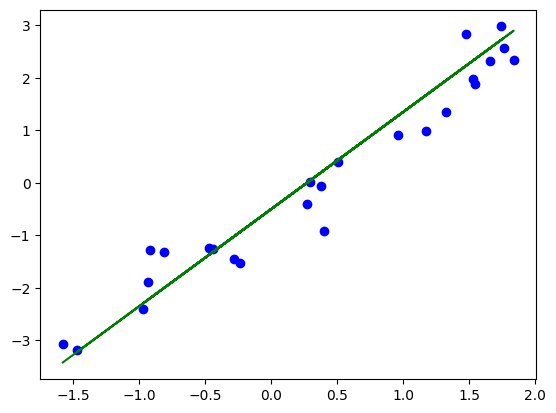

In [4]:
plt.scatter(x[:, 0], y[:, 0], c='b')
plt.plot(x[:, 0], x[:, 0] * slope + intercept, c='g')
plt.show()
plt.close()

Given our $X$ and $y$ data, we can now investigate various ways
to infer $\beta$ and $t$.

## Closed Form Solution

The linear regression model offers a closed form solution to solve for our parameters:

$$
\hat \beta = (X^TX)^{-1}X^Ty.
$$

Pytorch has the same functionality as numpy for matrix operations and
can be used in the exact same way.
A major advantage is the possibility to perform calculations on the
GPU without much overhead.

In [5]:
def estimate_beta(x: Tensor, y: Tensor) -> Tensor:
    """Get beta coefficient over closed form solution."""
    return torch.inverse(x.T @ x) @ x.T @ y


beta_hat = estimate_beta(x, y)
print('The estimated beta is {:.3f}.'.format(float(beta_hat[0])))

The estimated beta is 1.518.


Well, something is not right yet! The closed-form solution does
not have a dedicated intercept term.
This can be helped by a little trick:
From now on we add a 1 as an additional input feature to every $x \in X$,
which can be seen as a replacement of the bias.
This also allows to reuse the closed-form function without any adaptions.

In [6]:
x = torch.cat([x, torch.ones(25, 1)], dim=1)
print(x[:5])

beta_hat = estimate_beta(x, y)
print(
    'The estimated slope is {:.3f} and the intercept is {:.3f}.'.format(
        float(beta_hat[0]), float(beta_hat[1])
    )
)

tensor([[ 1.5291,  1.0000],
        [ 1.6600,  1.0000],
        [-0.4685,  1.0000],
        [ 1.8372,  1.0000],
        [-0.4382,  1.0000]])
The estimated slope is 1.669 and the intercept is -0.561.


We check how well the parameters approximate the linear function in a plot:

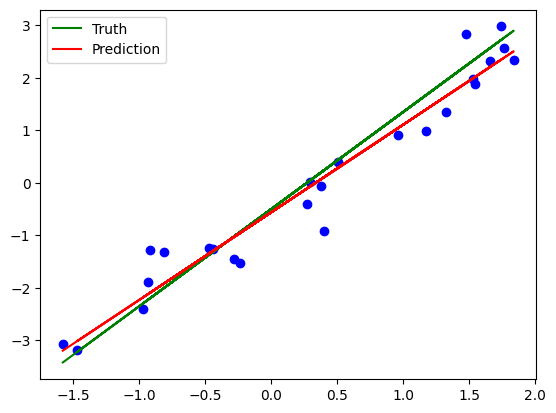

In [7]:
def plot_linear_regression(
    x: Tensor,
    y: Tensor,
    slope_true: float,
    intercept_true: float,
    slope_pred: float,
    intercept_pred: float,
) -> None:
    """Plot the result of a linear regression with known true parameters."""
    plt.scatter(x[:, 0], y[:, 0], c='b')
    plt.plot(x[:, 0], x[:, 0] * slope_true + intercept_true, c='g', label='Truth')
    plt.plot(x[:, 0], x[:, 0] * slope_pred + intercept_pred, c='r', label='Prediction')
    plt.legend(loc='upper left')
    plt.show()
    plt.close()


plot_linear_regression(
    x,
    y,
    slope_true=slope,
    intercept_true=intercept,
    slope_pred=float(beta_hat[0]),
    intercept_pred=float(beta_hat[1]),
)

That looks pretty close! Note that deviation in the output of the prediction
is directly influenced by the amount of $\epsilon$.

## Defining a Custom Function

Instead of going for a closed for the closed-form solution, we can tackle
the problem of linear regression over a batch-based iterative procedure
using a loss function.
In the next step we define a very extensive function, which fits into the
pytorch backpropagation API.
Essentially, the function computes the output of a linear regression with mean
squared error and,
when calling `.backward()` on the function output, computes the necessary
gradients for our parameter estimation.
Starting from now, we denote our $\hat \beta$ as weights $w$.

The mean squared error is defined as: $||Xw - y||^2_2$


In [8]:


class LinearRegressionLossFunction(Function):
    """Custom linear regression function."""

    @staticmethod
    def forward(ctx: Any, x: Tensor, w: Tensor, y: Tensor) -> Tensor:
        """Compute the forward pass aka model output."""
        # First, we compute the output of our model
        y_hat = x @ w
        # Next, we compute the mean squared error
        mse = torch.mean((y_hat - y) ** 2)

        # The "ctx" object serves to stash information
        # that we need for the backward pass
        ctx.save_for_backward(x, y_hat, y)

        # The function returns our computed error
        return mse

    @staticmethod
    def backward(ctx: Any, grad_output: Tensor) -> Tuple:
        """Compute the backward pass aka the gradients w.r.t. to function inputs."""
        # The "grad_output" parameter is the backpropagated gradient from subsequent
        # operations w.r.t. to the output of this function.

        # We collect the previously saved tensors
        x, y_hat, y = ctx.saved_tensors
        # Compute the gradient of the loss w.r.t. y_hat
        grad_y_hat = 2 * (y_hat - y) / len(y_hat)
        # Compute the gradient of the loss w.r.t. w
        grad_w = x.T @ grad_y_hat
        return None, grad_output * grad_w, None

With the above function, we can now compute a gradient for our $w$.

In [9]:
# Initialize parameter vector with small values
w = torch.randn((2, 1)) * 0.001
# Allow gradient computation for our parameters
w.requires_grad = True
# Compute the loss over our custom linear regression function.
loss = LinearRegressionLossFunction.apply(x, w, y)
# Backpropagate the error to our parameters
loss.backward()
# The gradients appear in the grad attribute of w
print(w.grad)

tensor([[-3.9442],
        [-0.0454]])


With this mechanism we are able to define a small training procedure,
which iteratively computes gradients of $w$ to minimize the MSE loss.


In [10]:
iterations = 50
learning_rate = 0.1

w = torch.randn((2, 1)) * 0.01
w.requires_grad = True

for i in range(iterations):
    # Remove gradients from previous iteration
    w.grad = None

    # Compute the loss and gradients
    loss = LinearRegressionLossFunction.apply(x, w, y)
    loss.backward()

    # Apply gradients with a learning rate
    with torch.no_grad():
        w -= w.grad * learning_rate  # type: ignore

print(
    'The estimated slope is {:.3f} and the intercept is {:.3f}.'.format(
        float(w[0]), float(w[1])
    )
)

The estimated slope is 1.669 and the intercept is -0.561.


The result is really close to our closed-form solution! Let's check the plot:

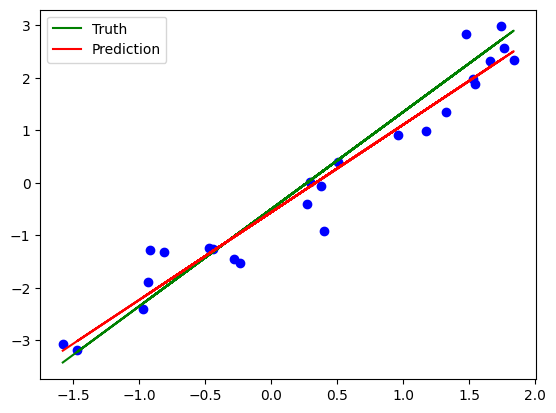

In [11]:
plot_linear_regression(
    x,
    y,
    slope_true=slope,
    intercept_true=intercept,
    slope_pred=float(w[0]),
    intercept_pred=float(w[1]),
)

## Using Autograd

Obviously, the above approach is for showcasing purposes only. Defining a custom
autograd function is necessary in some special cases, but one power of pytorch is
to do this all automatically! We don't need to compute our derivatives by hand.
The framework tracks elementary operations on a computational graph and allows
for the same functionality for nearly arbitrary functions out of the box.

In [12]:
# Initialize parameters as before
w = torch.randn((2, 1)) * 0.001
w.requires_grad = True

# Initialize convenient loss function
loss_func = MSELoss()

# Compute loss and propagate back
y_hat = x @ w
loss = loss_func(y_hat, y)
loss.backward()

print(w.grad)

tensor([[-3.9413],
        [-0.0465]])


Additionally, gradients don't need to be applied manually, if we define an
optimizer.
With slight modifications of the previous training loop, we achieve the same result.

In [13]:
iterations = 50
learning_rate = 0.1

w = torch.randn((2, 1)) * 0.01
w.requires_grad = True

# An optimizer applies the gradients for us
optimizer = SGD([w], lr=learning_rate)

for i in range(iterations):
    # Compute the loss and gradients
    y_hat = x @ w
    loss = loss_func(y_hat, y)

    # Remove gradients from previous iteration
    optimizer.zero_grad()
    # Backpropagate loss
    loss.backward()
    # Apply gradients
    optimizer.step()

print(
    'The estimated slope is {:.3f} and the intercept is {:.3f}.'.format(
        float(w[0]), float(w[1])
    )
)

The estimated slope is 1.669 and the intercept is -0.561.


## Using a neural network

With the above approach, we are extremely close to training neural networks.
In the current implementation the output of the linear regression is computed
over matrix multiplication.
This corresponds to a `Linear` layer in the terminology of pytorch.
The `Linear` layer also has an included bias, i.e. intercept, thus, we don't
need an additional input column for this anymore.

In [14]:
# We can now remove our "intercept column"
x = x[:, 0].unsqueeze(1)

In [15]:

model = Linear(
    # The input features correspond to the features of x
    in_features=x.shape[1],
    # The output features is 1 for univariate regression.
    out_features=1,
)

Again, the training loop is modified to allow training with a neural module.

In [16]:
iterations = 50
learning_rate = 0.1

# An optimizer applies the gradients for us
optimizer = SGD(model.parameters(), lr=learning_rate)

for i in range(iterations):
    # Compute the output of a pytorch model
    y_hat = model(x)
    loss = loss_func(y_hat, y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# The parameters we seek are attributes of the model.
print(
    'The estimated slope is {:.3f} and the intercept is {:.3f}.'.format(
        float(model.weight), float(model.bias)
    )
)

The estimated slope is 1.669 and the intercept is -0.561.


The linear regression is a very simple model and obviously enough for this
task, as we generated the data with linearity in mind.
However, exchanging the model is now pretty easy.
Let's see how our approximated function would look like if we choose a
more complex non-linear model.

In [17]:
# Dimension of hidden layers.
hidden_dim = 64
# With Sequential multiple layers can be stacked.
# LeakyRelu is chosen as an activation function for non-linearity.
model = Sequential(
    Linear(x.shape[1], hidden_dim),
    LeakyReLU(),
    Linear(hidden_dim, hidden_dim),
    LeakyReLU(),
    Linear(hidden_dim, hidden_dim),
    LeakyReLU(),
    Linear(hidden_dim, hidden_dim),
    LeakyReLU(),
    Linear(hidden_dim, 1),
)

In [18]:
iterations = 2500
learning_rate = 0.1

# An optimizer applies the gradients for us
optimizer = SGD(model.parameters(), lr=learning_rate)

for i in range(iterations):
    # Compute the output of a pytorch model
    y_hat = model(x)
    loss = loss_func(y_hat, y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if i % 100 == 0:
        print('ITER: {:5d} | LOSS: {:.4f}'.format(i, float(loss)))

    # print(loss)

ITER:     0 | LOSS: 3.4855
ITER:   100 | LOSS: 0.2751
ITER:   200 | LOSS: 0.2363
ITER:   300 | LOSS: 0.2087
ITER:   400 | LOSS: 0.1819
ITER:   500 | LOSS: 0.1716
ITER:   600 | LOSS: 0.1558
ITER:   700 | LOSS: 0.1462
ITER:   800 | LOSS: 0.1397
ITER:   900 | LOSS: 0.1191
ITER:  1000 | LOSS: 0.1066
ITER:  1100 | LOSS: 0.1128
ITER:  1200 | LOSS: 0.0971
ITER:  1300 | LOSS: 0.0952
ITER:  1400 | LOSS: 0.1040
ITER:  1500 | LOSS: 0.0977
ITER:  1600 | LOSS: 0.0901
ITER:  1700 | LOSS: 0.0865
ITER:  1800 | LOSS: 0.0955
ITER:  1900 | LOSS: 0.0884
ITER:  2000 | LOSS: 0.0831
ITER:  2100 | LOSS: 0.0970
ITER:  2200 | LOSS: 0.0821
ITER:  2300 | LOSS: 0.0991
ITER:  2400 | LOSS: 0.0782


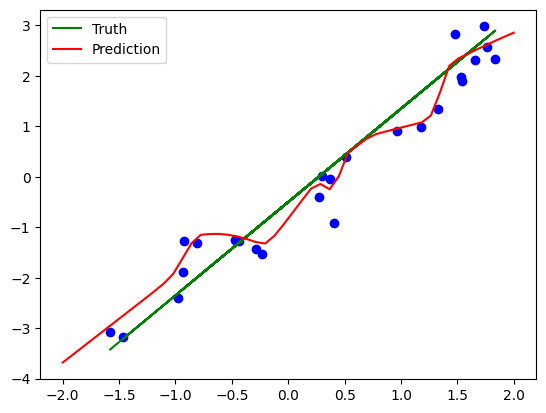

In [19]:
plt.scatter(x[:, 0], y[:, 0], c='b')
plt.plot(x[:, 0], x[:, 0] * slope + intercept, c='g', label='Truth')

inp = torch.linspace(-2, 2, 50)
out = model(inp.unsqueeze(1)).squeeze().detach()
plt.plot(inp, out, c='r', label='Prediction')

plt.legend(loc='upper left')
plt.show()
plt.close()

Well, that doesn't look like a linear function at all anymore!
The model is too complex and learns to approximate the noise on our data.
This is a case of severe overfitting and should be avoided.